In [37]:
# import pytube
# import moviepy.editor as mp
from dtw import dtw
import io
import matplotlib.pyplot as plt
import numpy as np
import librosa
import IPython.display
from IPython.display import Image
import copy
import os
import json
import soundfile as sf
import concurrent.futures
import temp
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})

In [4]:
def preprocess_mfcc(mfcc):
    mfcc_cp = copy.deepcopy(mfcc)
    for i in range(mfcc.shape[1]):
        mfcc_cp[:,i] = mfcc[:,i] - np.mean(mfcc[:,i])
        mfcc_cp[:,i] = mfcc_cp[:,i]/np.max(np.abs(mfcc_cp[:,i]))
    return mfcc_cp

In [5]:
def get_timeRange(dists:list, window_size:int):
    # smallest value index
    word_match_idx = dists.argmin()
    # get index bounds
    word_match_idx_bnds = np.array([word_match_idx, np.ceil(word_match_idx+window_size)])
    samples_per_mfcc = 512
    # get time bounds
    word_samp_bounds = word_match_idx_bnds*samples_per_mfcc
    return (int(word_samp_bounds[0]),int(word_samp_bounds[1]))

## Download audio

In [6]:
url = r'https://youtu.be/OnAA1dIG6iY'

In [7]:
youtube = pytube.YouTube(url)
video = youtube.streams.get_highest_resolution()
video.download()
video_title = video.default_filename
print(video_title)

J&T  Sistem Pengagihan Bonus Tak Jelas.mp4


In [8]:
clip = mp.VideoFileClip(video_title) 
audio_file_name = video_title[:-4]+ ".wav"
clip.audio.write_audiofile(audio_file_name)

chunk:   0%|                                                                        | 0/2109 [00:00<?, ?it/s, now=None]

MoviePy - Writing audio in J&T  Sistem Pengagihan Bonus Tak Jelas.wav


MoviePy - Done.


## Constants

In [8]:
# == Constants ==
FULL_SENTENCE = 'kurang jelas terhadap sistem pengagihan bonus dalam kalangan pegawai jabatan menjadi punca kepada kejadian mogok dan tindakan melempar barangan milik pelanggan oleh kakitangan J&T Express'
SAMPLE_WORDS = FULL_SENTENCE.split()
TARGET_AUDIO_NAME = 'J&T Sistem Pengagihan Bonus Tak Jelas.mp3'
TARGET_URL = r'https://youtu.be/OnAA1dIG6iY'
PARENT_FOLDER = r'..\static'
# == Folder Names ==
FULL_TARGET_FOLDER = 'full'
SAMPLE_FOLDER_1 = 'sample 1'
SAMPLE_FOLDER_2 = 'sample 2'
GRAPH_FOLDER_1 = 'graph 1'
GRAPH_FOLDER_2 = 'graph 2'
DETECTED_FOLDER_1 = 'detected 1'
DETECTED_FOLDER_2 = 'detected 2'
# == Librosa Audio ==
AUDIO_SAMPLE_1 = []
AUDIO_SAMPLE_2 = []
TARGET_FULL_AUDIO = None
TARGET_FULL_RATE = None
# == MFCC ==
MFCC_SAMPLE_1 = []
MFCC_SAMPLE_2 = []
TARGET_FULL_MFCC = None
# == WINDOW ==
WINDOW_SIZE_1 = []
WINDOW_SIZE_2 = []
# == DISTANCE 2D LISTS==
DIST_2D_1 = []
DIST_2D_2 = []
# == TIME RANGES LIST ==
TIME_RANGE_1 = []
TIME_RANGE_2 = []
# =========================

## Read audio sample 1

In [9]:
%%time
for i, word in enumerate(SAMPLE_WORDS):
    full_name = f'{i+1}_{word}.mp3'
    audio, rate = librosa.load(os.path.join(PARENT_FOLDER, SAMPLE_FOLDER_1, full_name))
    AUDIO_SAMPLE_1.append((audio, rate))
    
print(len(AUDIO_SAMPLE_1))

C:\Users\TING WEI JING\AppData\Roaming\Python\Python38\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
25
Wall time: 12 s


## Read audio sample 2

In [10]:
%%time
for i, word in enumerate(SAMPLE_WORDS):
    full_name = f'{i+1}_{word}.mp3'
    audio, rate = librosa.load(os.path.join(PARENT_FOLDER, SAMPLE_FOLDER_2, full_name))
    AUDIO_SAMPLE_2.append((audio, rate))
    
print(len(AUDIO_SAMPLE_2))

25
Wall time: 11.2 s


## Read target audio

In [11]:
TARGET_FULL_AUDIO, TARGET_FULL_RATE = librosa.load(os.path.join(PARENT_FOLDER, FULL_TARGET_FOLDER, TARGET_AUDIO_NAME))
print(TARGET_FULL_RATE)

22050


## Preprocess Sample 1

In [12]:
%%time
# get mfcc for each audio samples
for i, (sample_audio, sample_rate) in enumerate(AUDIO_SAMPLE_1):
    x_mfcc = librosa.feature.mfcc(sample_audio, sample_rate)
    x_mfcc = preprocess_mfcc(x_mfcc)
    MFCC_SAMPLE_1.append((x_mfcc,sample_rate))
    
print(len(MFCC_SAMPLE_1))

25
Wall time: 254 ms


## Preprocess Sample 2

In [13]:
%%time
# get mfcc for each audio samples
for i, (sample_audio, sample_rate) in enumerate(AUDIO_SAMPLE_2):
    x_mfcc = librosa.feature.mfcc(sample_audio, sample_rate)
    x_mfcc = preprocess_mfcc(x_mfcc)
    MFCC_SAMPLE_2.append((x_mfcc,sample_rate))
    
print(len(MFCC_SAMPLE_2))

25
Wall time: 254 ms


## Preprocess Target

In [14]:
# get mfcc for target audio
TARGET_FULL_MFCC = preprocess_mfcc(librosa.feature.mfcc(TARGET_FULL_AUDIO, TARGET_FULL_RATE))
print(TARGET_FULL_MFCC.shape)

(20, 553)


## Checking

In [15]:
# check target audio
print(f'{TARGET_AUDIO_NAME}：{TARGET_FULL_MFCC.shape}')

J&T Sistem Pengagihan Bonus Tak Jelas.mp3：(20, 553)


In [20]:
# check audio samples 1
for i, (sample_mfcc, sample_rate) in enumerate(MFCC_SAMPLE_1):
    print(f'{SAMPLE_WORDS[i]}：{sample_mfcc.shape}')

kurang：(20, 18)
jelas：(20, 16)
terhadap：(20, 17)
sistem：(20, 26)
pengagihan：(20, 27)
bonus：(20, 21)
dalam：(20, 15)
kalangan：(20, 24)
pegawai：(20, 30)
jabatan：(20, 24)
menjadi：(20, 21)
punca：(20, 24)
kepada：(20, 19)
kejadian：(20, 20)
mogok：(20, 21)
dan：(20, 12)
tindakan：(20, 21)
melempar：(20, 34)
barangan：(20, 17)
milik：(20, 13)
pelanggan：(20, 22)
oleh：(20, 9)
kakitangan：(20, 25)
J&T：(20, 29)
Express：(20, 24)


In [21]:
# check audio samples 2
for i, (sample_mfcc, sample_rate) in enumerate(MFCC_SAMPLE_2):
    print(f'{SAMPLE_WORDS[i]}：{sample_mfcc.shape}')

kurang：(20, 17)
jelas：(20, 17)
terhadap：(20, 16)
sistem：(20, 21)
pengagihan：(20, 29)
bonus：(20, 20)
dalam：(20, 23)
kalangan：(20, 31)
pegawai：(20, 20)
jabatan：(20, 26)
menjadi：(20, 22)
punca：(20, 21)
kepada：(20, 17)
kejadian：(20, 21)
mogok：(20, 20)
dan：(20, 12)
tindakan：(20, 23)
melempar：(20, 29)
barangan：(20, 21)
milik：(20, 15)
pelanggan：(20, 21)
oleh：(20, 12)
kakitangan：(20, 31)
J&T：(20, 37)
Express：(20, 35)


## DTW 1

In [16]:
# get window sizes for each audio samples
WINDOW_SIZE_1 = np.array([int(MFCC_SAMPLE_1[i][0].shape[1]//1) for i in range(len(MFCC_SAMPLE_1))])
print(WINDOW_SIZE_1)

[18 16 17 26 27 21 15 24 30 24 21 24 19 20 21 12 21 34 17 13 22  9 25 29
 24]


In [17]:
%%time
import temp

arguments = [(TARGET_FULL_MFCC, MFCC_SAMPLE_1[i][0], WINDOW_SIZE_1[i]) for i in range(len(SAMPLE_WORDS))]
with concurrent.futures.ProcessPoolExecutor(max_workers=3) as executor:
    results = executor.map(temp.word_spoken_DTW, *zip(*arguments))

DIST_2D_1 = list(results)
print(len(DIST_2D_1))

25
Wall time: 1min 13s


In [18]:
plt.rcParams["figure.figsize"] = (10,40)

In [19]:
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

25


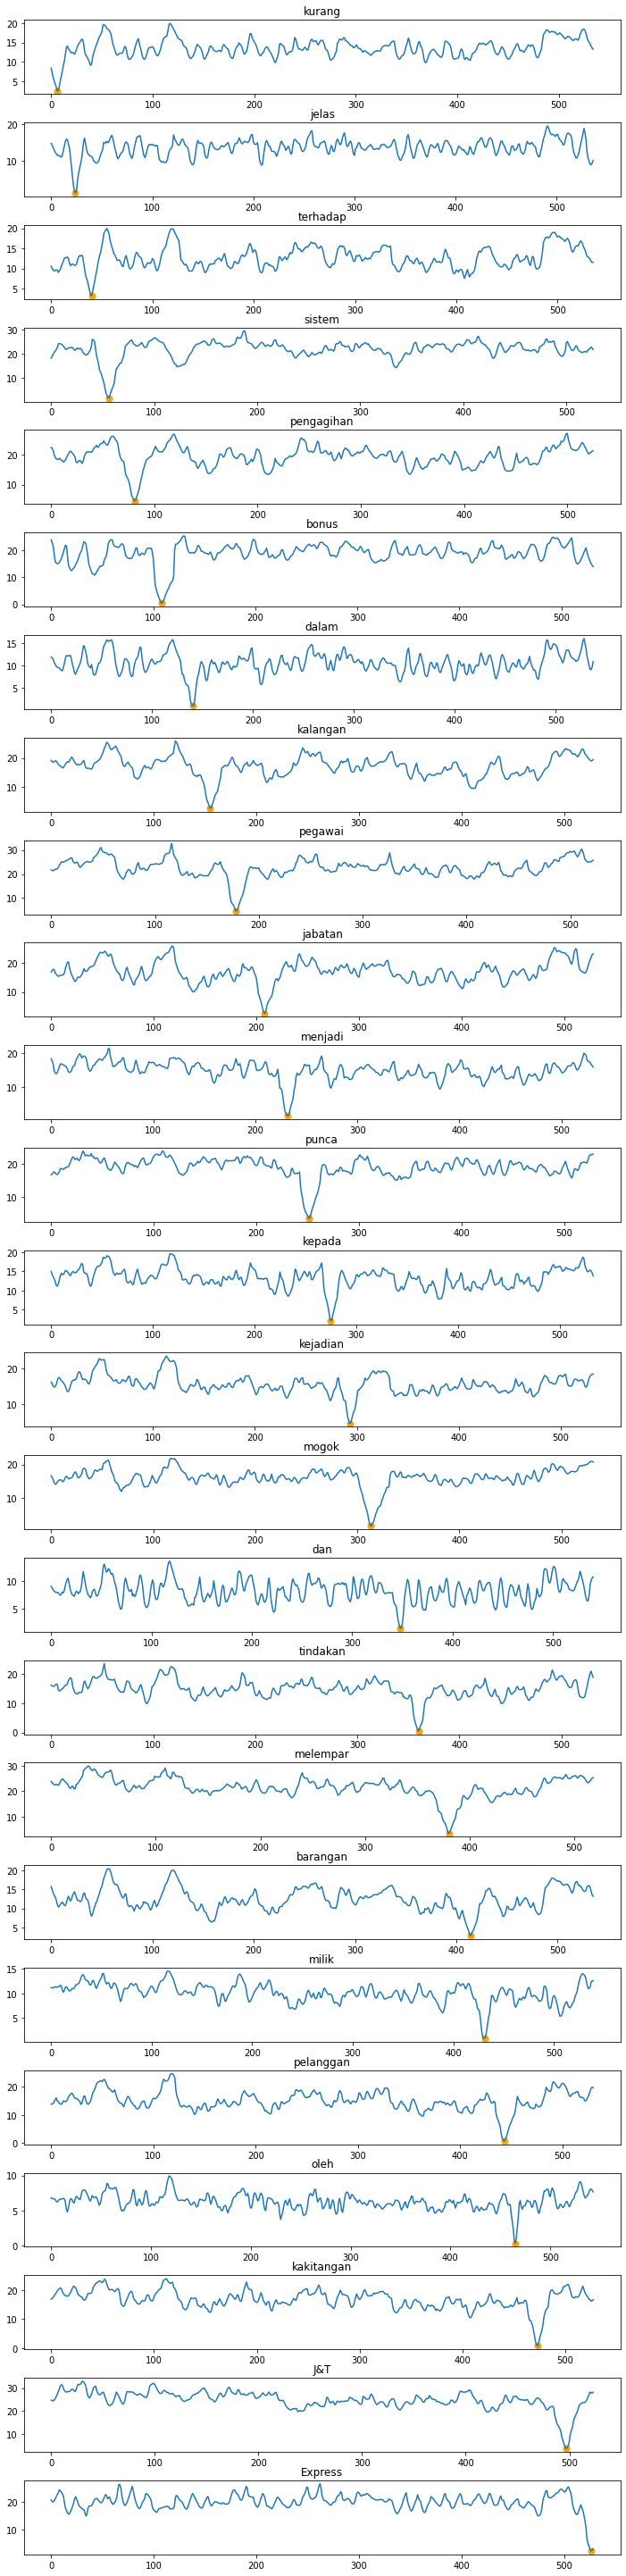

In [19]:
fig, axs = plt.subplots(len(DIST_2D_1))
fig.tight_layout()
print(len(axs))
for i in range(len(axs)):
    smallest_idx = DIST_2D_1[i].argmin()
    axs[i].set_title(SAMPLE_WORDS[i])
    axs[i].scatter(smallest_idx, DIST_2D_1[i][smallest_idx], s=50, color='orange')
    axs[i].plot(DIST_2D_1[i])

Wall time: 11 s


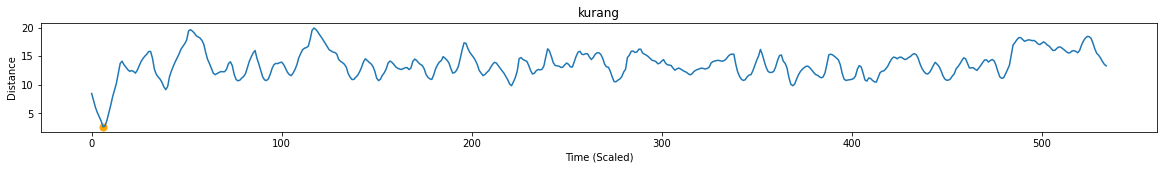

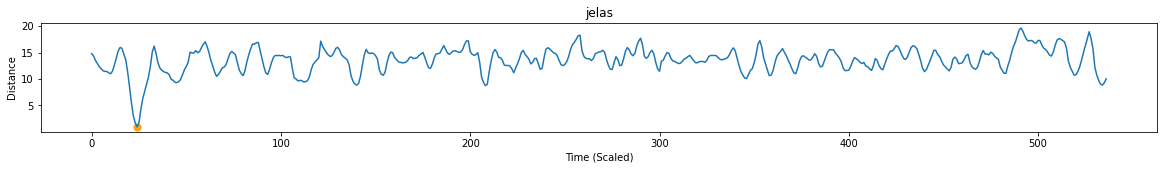

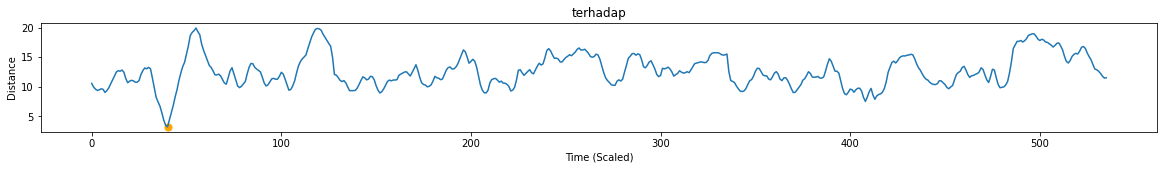

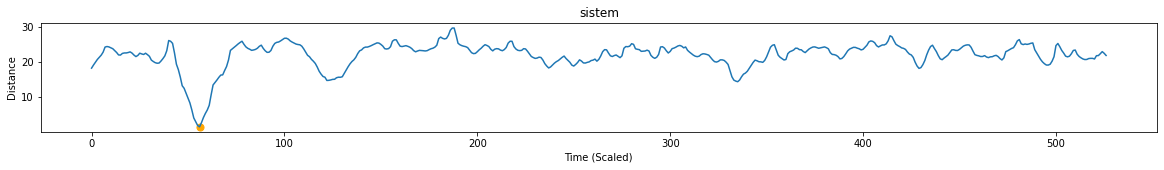

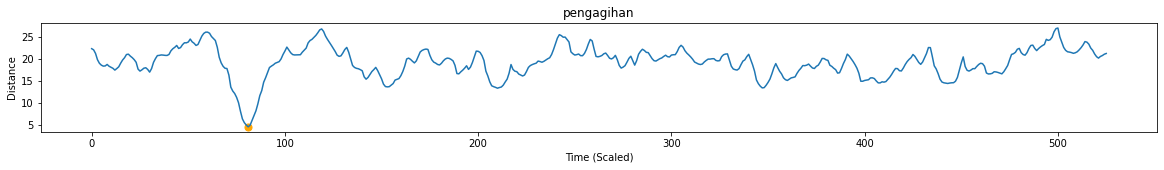

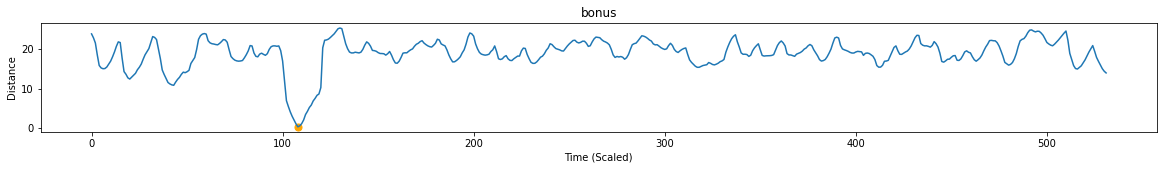

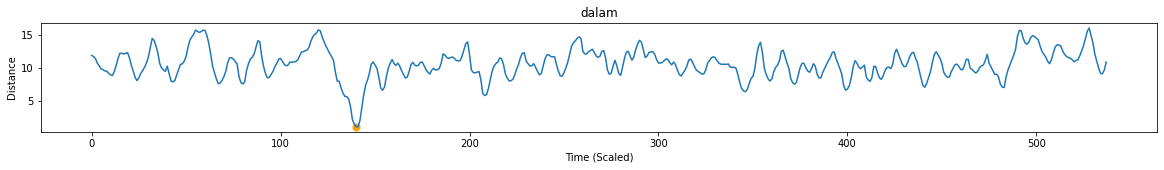

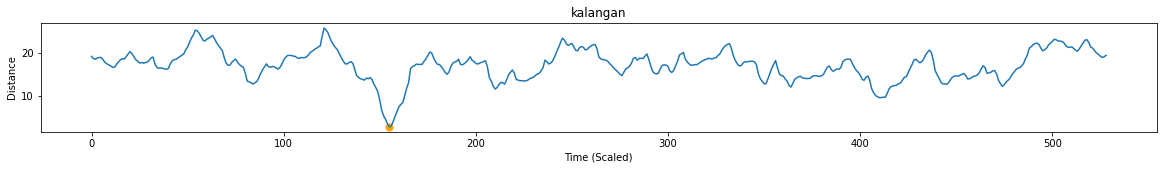

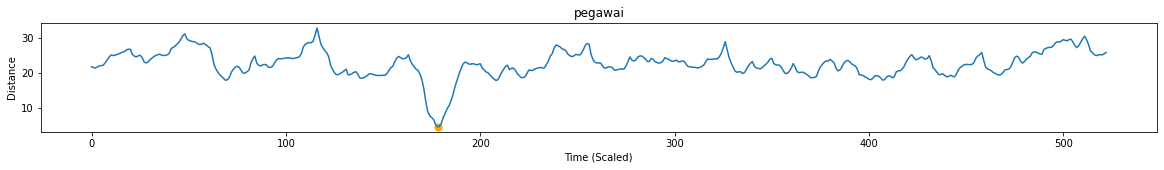

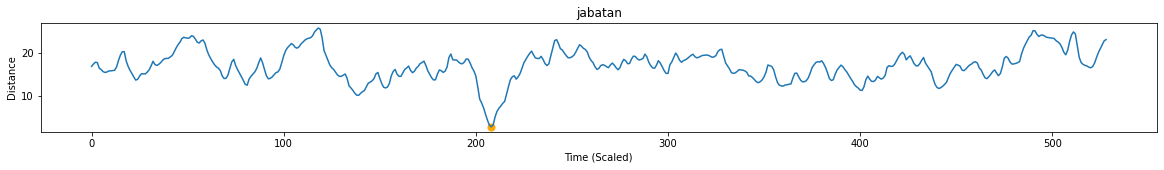

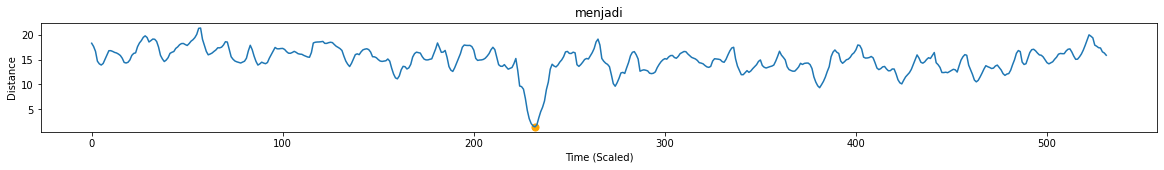

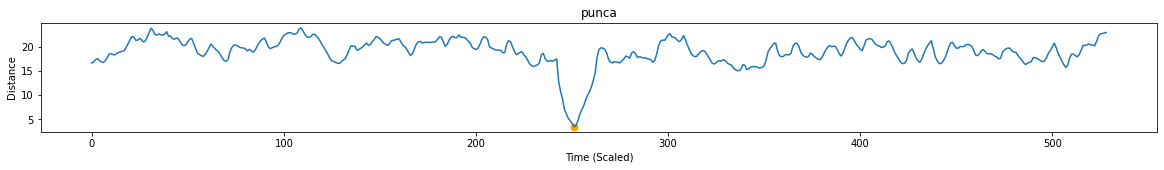

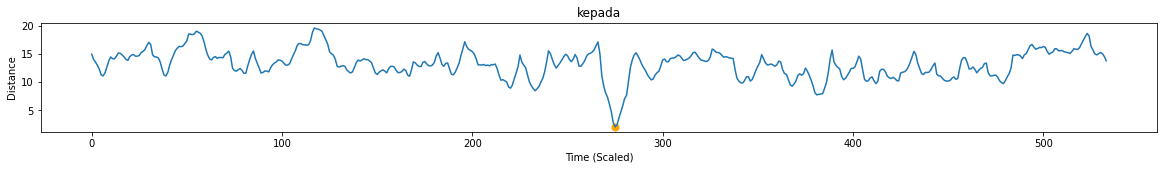

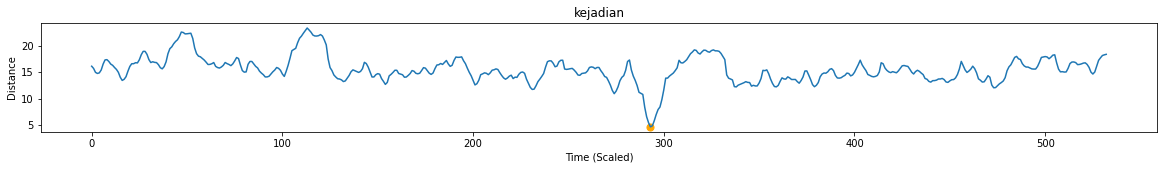

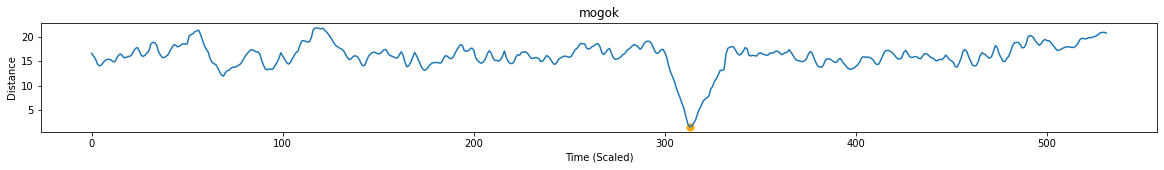

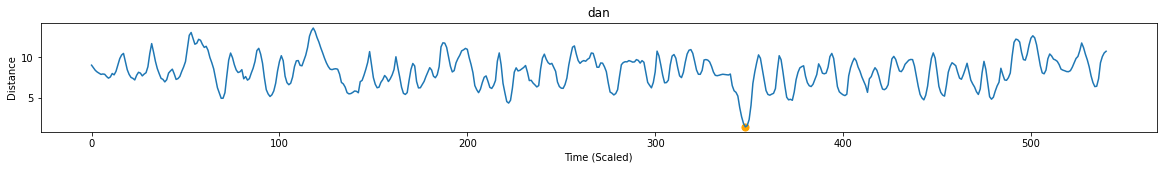

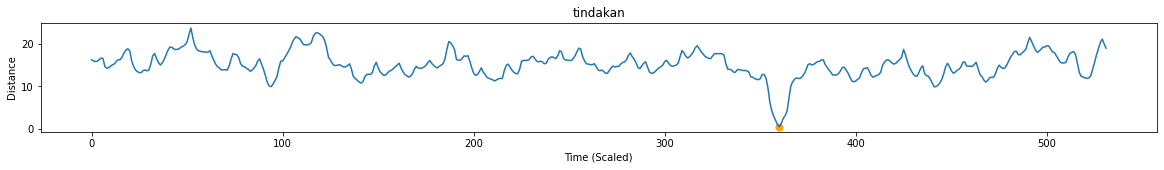

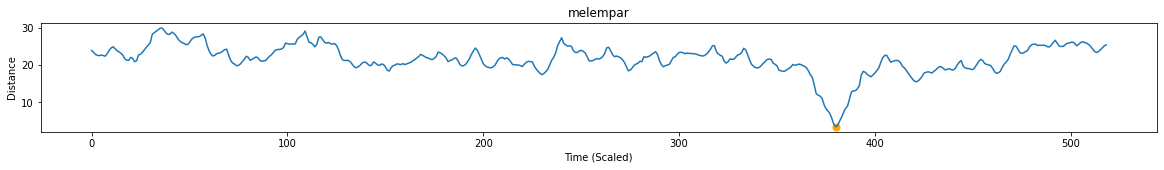

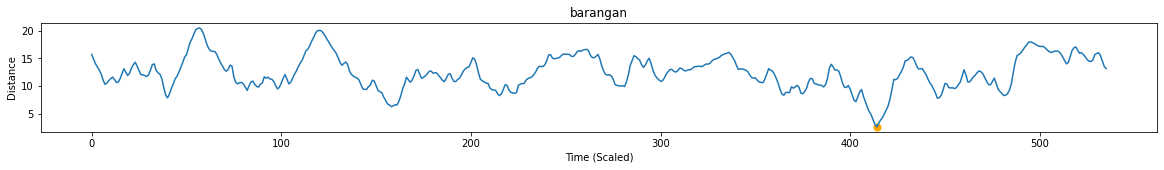

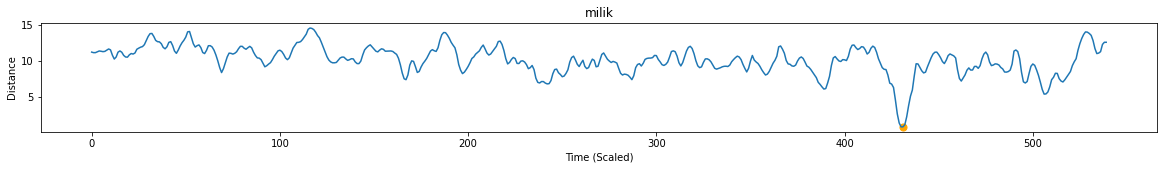

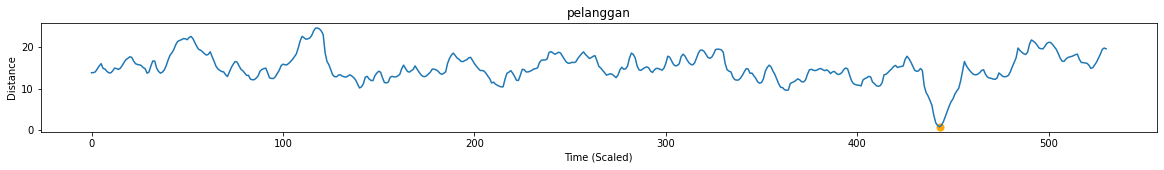

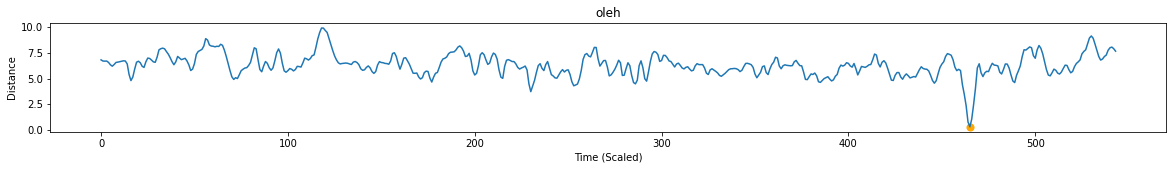

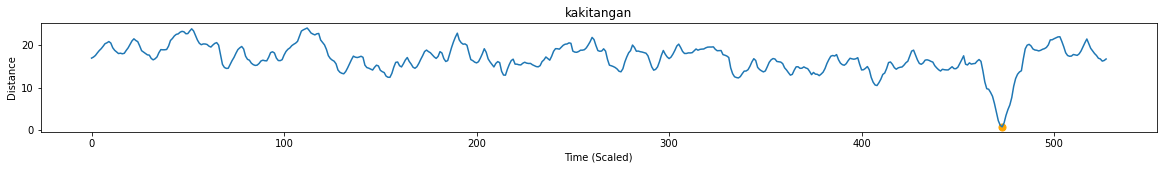

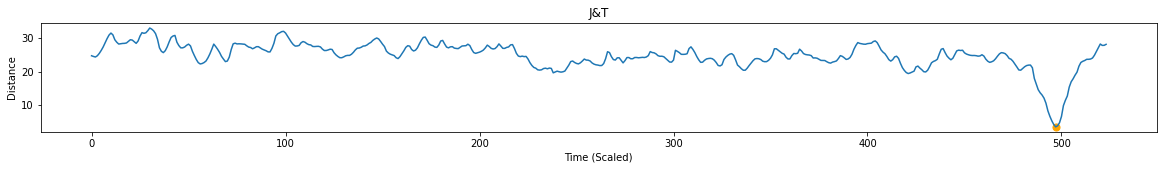

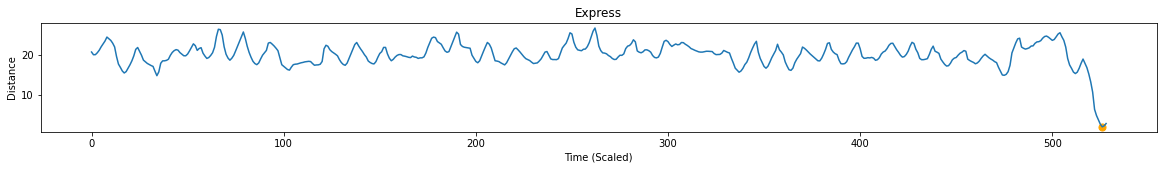

In [23]:
%%time
# save to jpg
plt.rcParams['figure.figsize'] = (20, 2)

for i in range(len(DIST_2D_1)):
    smallest_idx = DIST_2D_1[i].argmin()
    fig, ax = plt.subplots()
    ax.set_title(SAMPLE_WORDS[i])
    ax.set_xlabel('Time (Scaled)')
    ax.set_ylabel('Distance')
    ax.plot(DIST_2D_1[i])
    ax.scatter(smallest_idx, DIST_2D_1[i][smallest_idx], s=50, color='orange')
    fig.savefig(fname=os.path.join(PARENT_FOLDER, GRAPH_FOLDER_1, f'{i+1}_{SAMPLE_WORDS[i]}.jpg'), dpi=200, bbox_inches='tight', pad_inches=0.1)

In [24]:
TIME_RANGE_1 = []
for i in range(len(SAMPLE_WORDS)):
    time = get_timeRange(DIST_2D_1[i], WINDOW_SIZE_1[i])
    TIME_RANGE_1.append(time)
    
print(len(TIME_RANGE_1))

25


## DTW 2

In [25]:
# get window sizes for each audio samples
WINDOW_SIZE_2 = np.array([int(MFCC_SAMPLE_2[i][0].shape[1]//1) for i in range(len(MFCC_SAMPLE_2))])
print(WINDOW_SIZE_2)

[17 17 16 21 29 20 23 31 20 26 22 21 17 21 20 12 23 29 21 15 21 12 31 37
 35]


In [26]:
%%time
import temp

arguments = [(TARGET_FULL_MFCC, MFCC_SAMPLE_2[i][0], WINDOW_SIZE_2[i]) for i in range(len(SAMPLE_WORDS))]
with concurrent.futures.ProcessPoolExecutor(max_workers=3) as executor:
    results = executor.map(temp.word_spoken_DTW, *zip(*arguments))

DIST_2D_2 = list(results)
print(len(DIST_2D_2))

25
Wall time: 1min 27s


In [27]:
plt.rcParams["figure.figsize"] = (10,40)

In [28]:
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

25


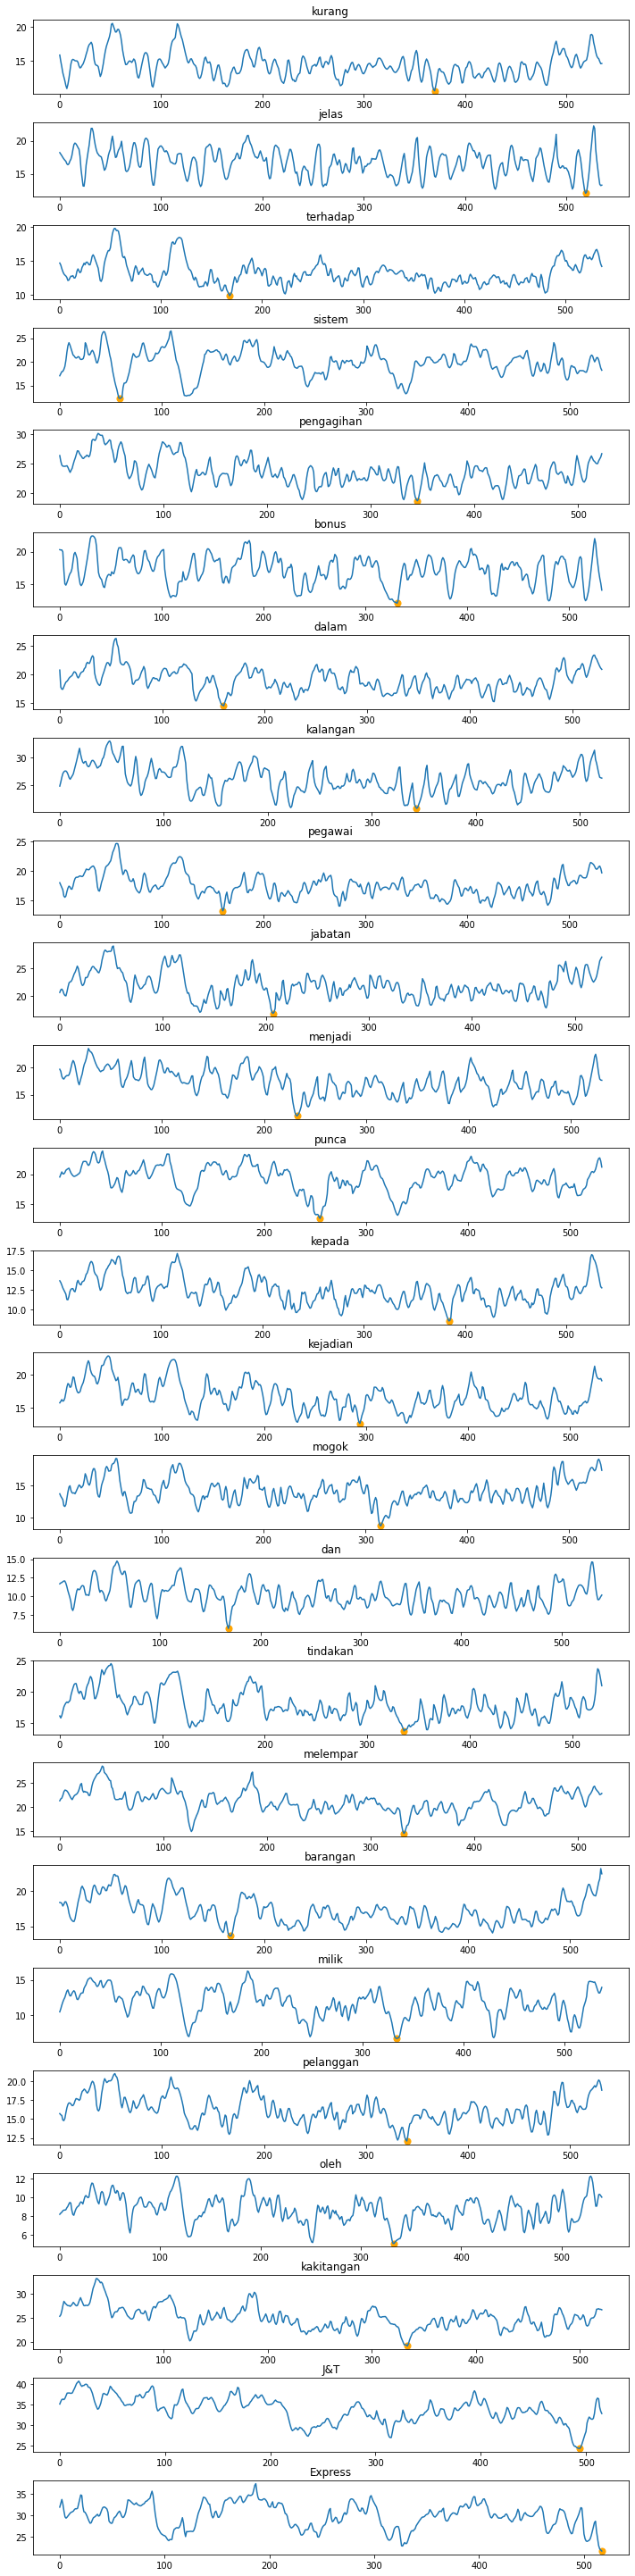

In [28]:
fig, axs = plt.subplots(len(DIST_2D_2))
fig.tight_layout()
print(len(axs))
for i in range(len(axs)):
    smallest_idx = DIST_2D_2[i].argmin()
    axs[i].set_title(SAMPLE_WORDS[i])
    axs[i].plot(DIST_2D_2[i])
    axs[i].scatter(smallest_idx, DIST_2D_2[i][smallest_idx], s=50, color='orange')

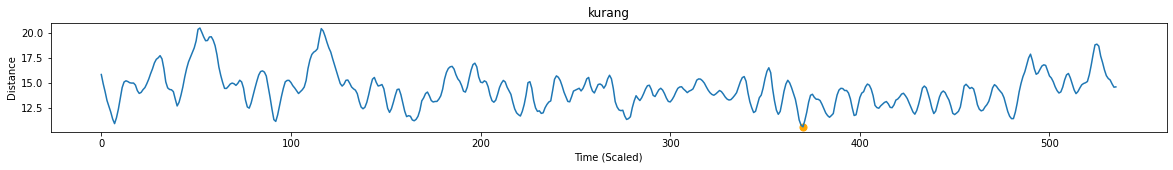

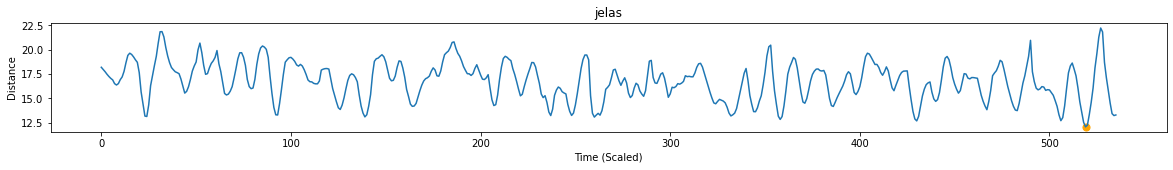

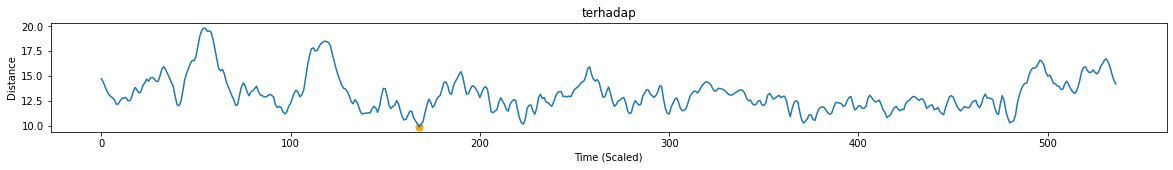

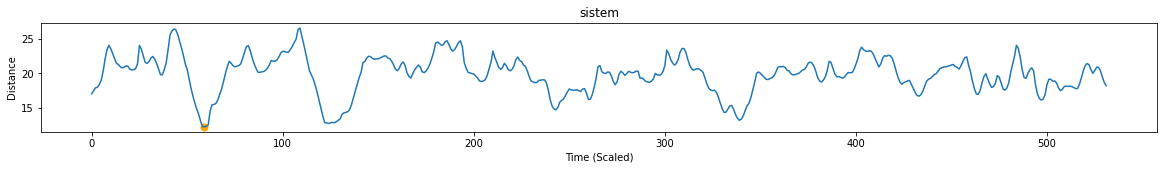

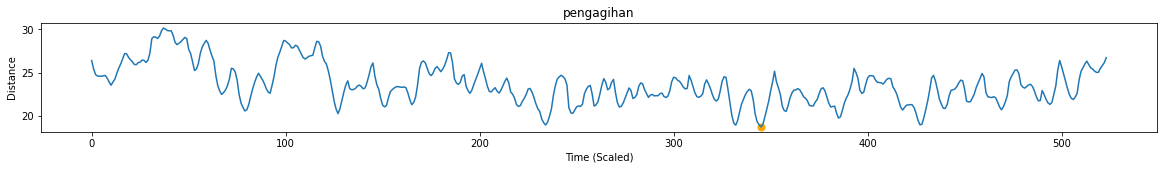

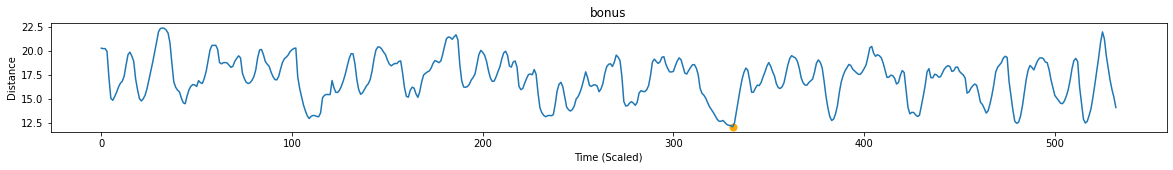

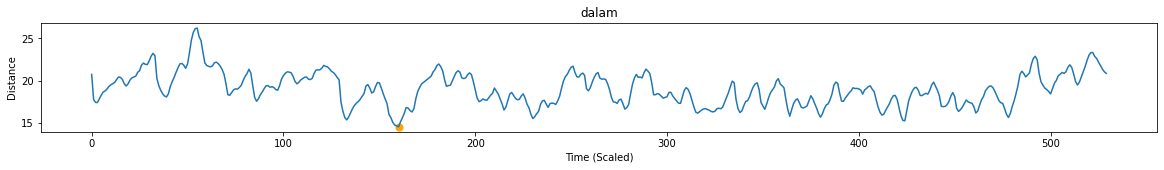

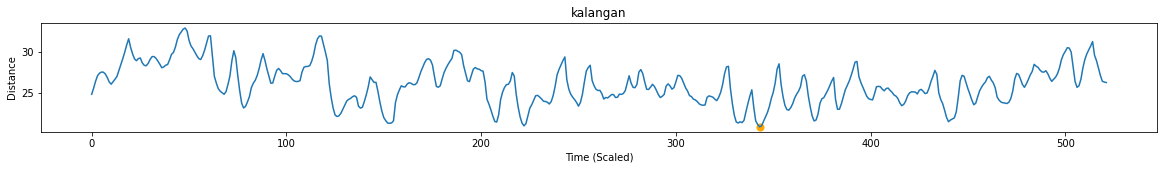

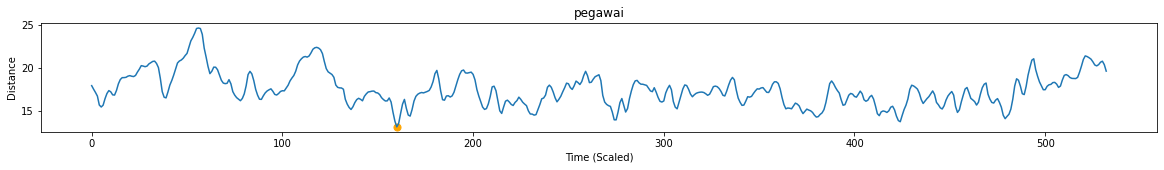

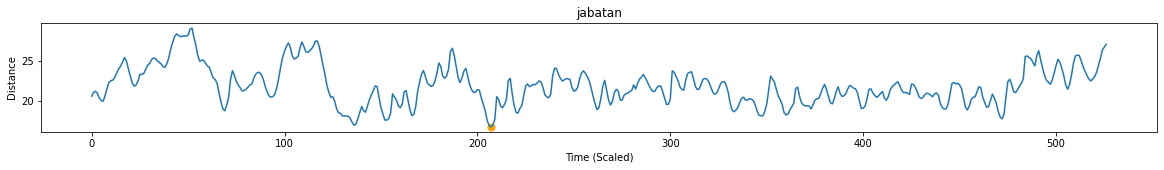

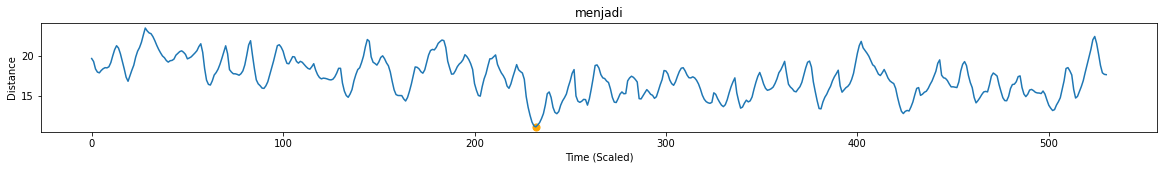

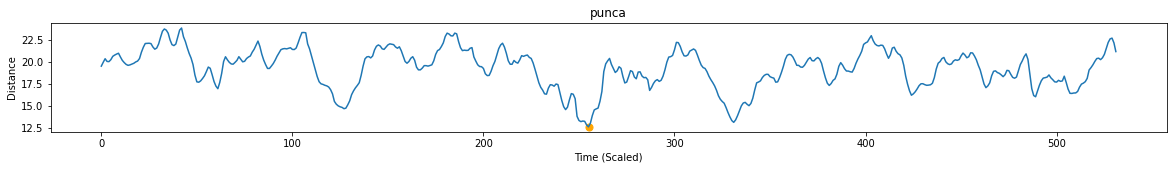

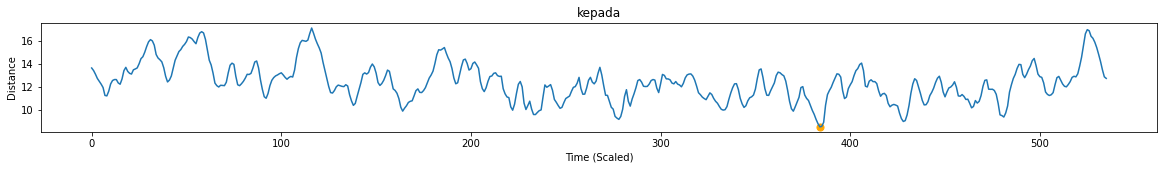

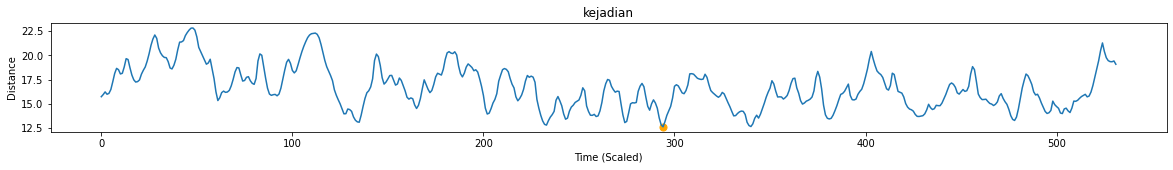

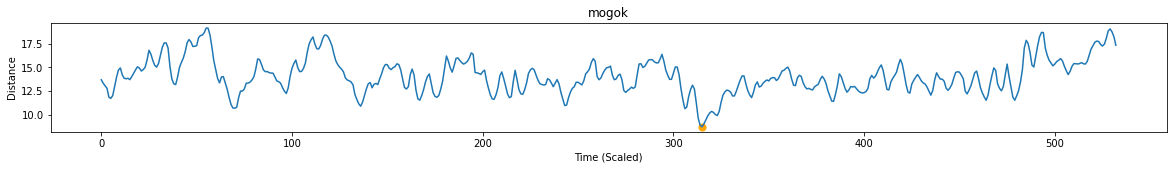

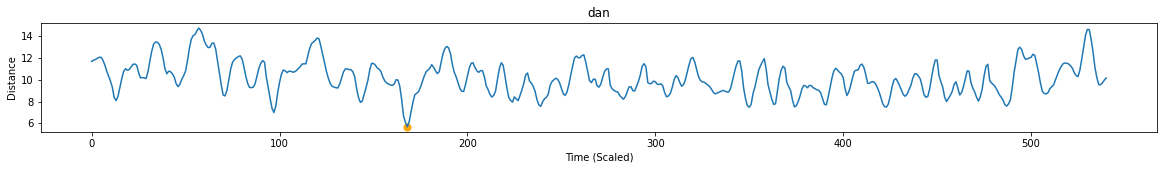

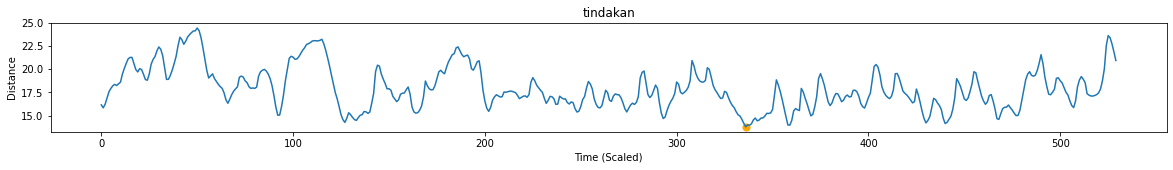

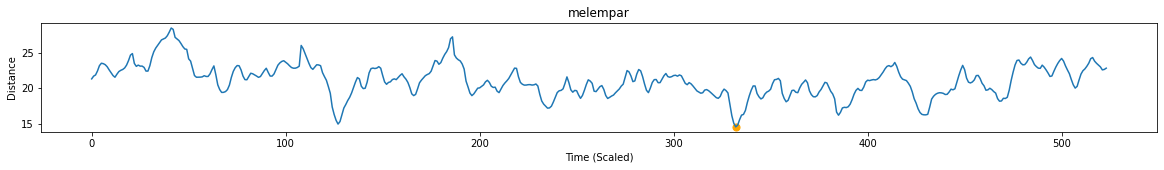

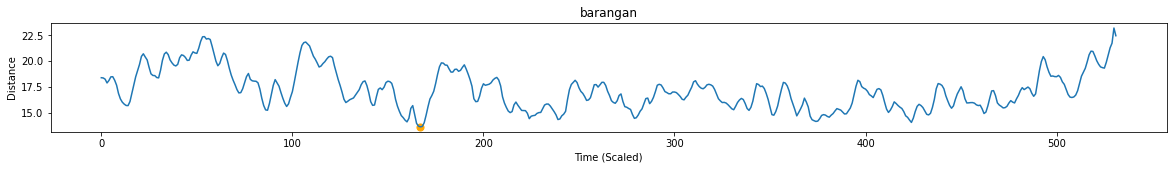

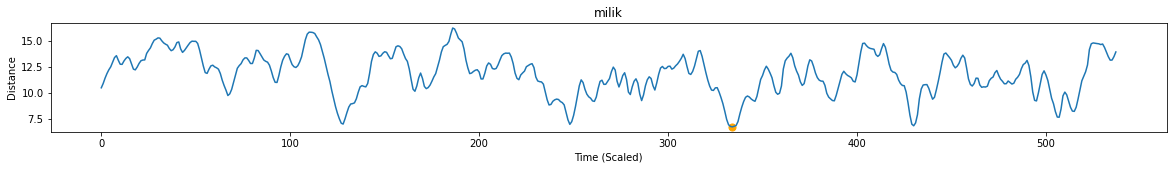

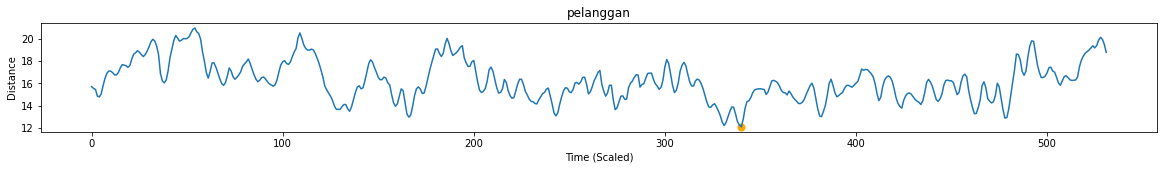

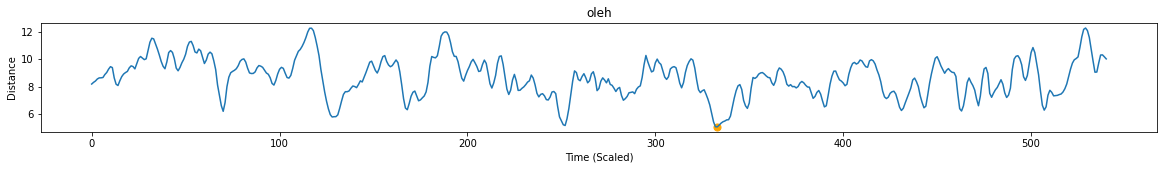

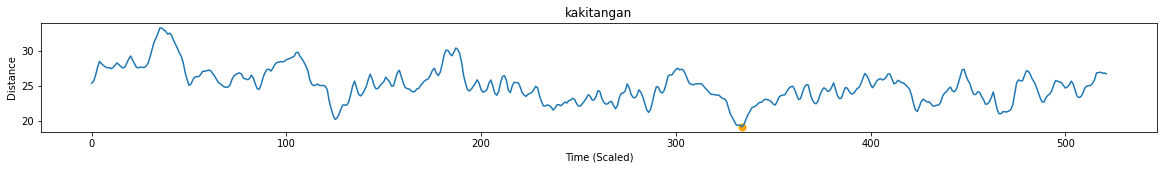

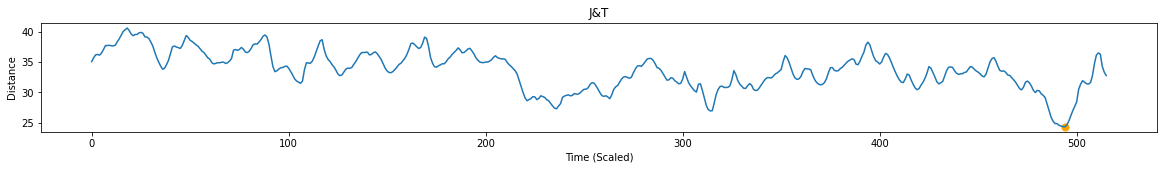

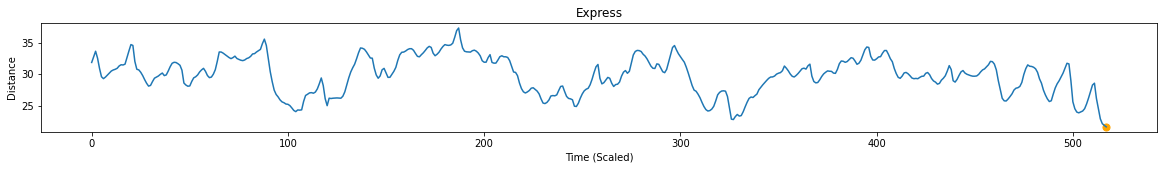

In [29]:
# save to jpg
plt.rcParams['figure.figsize'] = (20, 2)

for i in range(len(DIST_2D_2)):
    smallest_idx = DIST_2D_2[i].argmin()
    fig, ax = plt.subplots()
    ax.set_title(SAMPLE_WORDS[i])
    ax.set_xlabel('Time (Scaled)')
    ax.set_ylabel('Distance')
    ax.scatter(smallest_idx, DIST_2D_2[i][smallest_idx], s=50, color='orange')
    ax.plot(DIST_2D_2[i])
    fig.savefig(fname=os.path.join(PARENT_FOLDER, GRAPH_FOLDER_2, f'{i+1}_{SAMPLE_WORDS[i]}.jpg'), dpi=200, bbox_inches='tight', pad_inches=0.1)

In [34]:
TIME_RANGE_2 = []
for i in range(len(SAMPLE_WORDS)):
    time = get_timeRange(DIST_2D_2[i], WINDOW_SIZE_2[i])
    TIME_RANGE_2.append(time)
    
print(len(TIME_RANGE_2))

25


## Postprocess

In [38]:
def save_mp3(audio, rate, outFile):
    '''Write out audio as 24bit PCM WAV'''
    sf.write(outFile, audio, rate, subtype='PCM_24')

In [39]:
%%time
# save to file
for i, word in enumerate(SAMPLE_WORDS):
    # sample 1
    detected_path_1 = os.path.join(PARENT_FOLDER, DETECTED_FOLDER_1, f'{i+1}_{word}.wav')
    data_1 = TARGET_FULL_AUDIO[TIME_RANGE_1[i][0]:TIME_RANGE_1[i][1]]
    rate_1 = AUDIO_SAMPLE_1[i][1]
    save_mp3(data_1, rate_1, detected_path_1)
    # sample 2
    detected_path_2 = os.path.join(PARENT_FOLDER, DETECTED_FOLDER_2, f'{i+1}_{word}.wav')
    data_2 = TARGET_FULL_AUDIO[TIME_RANGE_2[i][0]:TIME_RANGE_2[i][1]]
    rate_2 = AUDIO_SAMPLE_2[i][1]
    save_mp3(data_2, rate_2, detected_path_2)

Wall time: 248 ms


In [40]:
%%time
# save to json
raw_data = {}

# target
full_target_audio_data = {
    "audio_title":TARGET_AUDIO_NAME,
    "source_link":TARGET_URL,
    "target_audio_path":os.path.join(PARENT_FOLDER, FULL_TARGET_FOLDER, TARGET_AUDIO_NAME).replace("\\","/"),
    "transcript":FULL_SENTENCE
}

raw_data["full_target_audio"] = full_target_audio_data

# sample 1
sample_audio_1_data = []
# sample 2
sample_audio_2_data = []

for i, word in enumerate(SAMPLE_WORDS):
    # sample 1
    img_path = os.path.join(PARENT_FOLDER, GRAPH_FOLDER_1, f'{i+1}_{word}.jpg').replace("\\","/")
    actual_audio_path = os.path.join(PARENT_FOLDER, SAMPLE_FOLDER_1, f'{i+1}_{word}.mp3').replace("\\","/")
    detected_audio_path = os.path.join(PARENT_FOLDER, DETECTED_FOLDER_1, f'{i+1}_{word}.wav').replace("\\","/")
    
    data = {
        "actual_word":word,
        "graph_img_path":img_path,
        "actual_audio_path":actual_audio_path,
        "detected_audio_path":detected_audio_path
    }
    sample_audio_1_data.append(data)

    # sample 2
    img_path = os.path.join(PARENT_FOLDER, GRAPH_FOLDER_2, f'{i+1}_{word}.jpg').replace("\\","/")
    actual_audio_path = os.path.join(PARENT_FOLDER, SAMPLE_FOLDER_2, f'{i+1}_{word}.mp3').replace("\\","/")
    detected_audio_path = os.path.join(PARENT_FOLDER, DETECTED_FOLDER_2, f'{i+1}_{word}.wav').replace("\\","/")
    
    data = {
        "actual_word":word,
        "graph_img_path":img_path,
        "actual_audio_path":actual_audio_path,
        "detected_audio_path":detected_audio_path
    }
    sample_audio_2_data.append(data)
    
raw_data["sample_audio_1"] = sample_audio_1_data
raw_data["sample_audio_2"] = sample_audio_2_data


# print(json.dumps(raw_data, indent=4))
with open('data.json', 'w') as outfile:
    json.dump(raw_data, outfile, indent=4)

Wall time: 8 ms
